### <center> In this notebook i will load the ASCAT and QuikSCAT dataset and merge them in a single scatterometer wind dataset. 

The approach is quite simple: first the QuikSCAT and ASCAT will be loaded in the overlapping period, then a simple linear regression will be built based on this data. Finally the linear regression will be used to correct ascat data towards quikscat-kind values. When coefficients are done, they will be stored on disk for future use. Then with the create_hovmoller_scatterometers.ipynb notebook the ascat hovmoller will be computed based on the correction with this coefficients ($QuikSCAT = A(lat,lon) \cdot ASCAT + B(lat,lon)$). That is the global idea... lets see if it works

In [113]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from airsea.windstress import stress
import scipy.stats as st
# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [2]:
# Define the overlapping period
overlap_period = pd.date_range('2007-03-21 12:00:00','2009-11-17 12:00:00', freq='d')

In [3]:
def preprocess(data):
    """
    Simple preprocessing function to apply to every ascat/quikscat file
    This just changes some names and modify the lon coordinate
    from -180-180 to 0-360
    """
    print(data.time.dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze().drop('depth')
    data = data[['wind_stress',
                 'surface_downward_eastward_stress',
                 'surface_downward_northward_stress',
                 'eastward_wind',
                 'northward_wind',
                 'wind_speed']]
    data = data.rename({'wind_stress':'tau',
                 'surface_downward_eastward_stress':'taux',
                 'surface_downward_northward_stress':'tauy',
                 'eastward_wind':'u',
                 'northward_wind':'v',
                 'wind_speed':'ws'})
    data = data.sel(lat=slice(-60,60))
    data.coords['lon'] = xr.where(data.lon<0,data.lon+360,data.lon)
    data = data.sortby('lon')#.sel(lon=slice(110,291))
    return data.compute()

# load ascat in the overlapping period
ascat = [glob('data/ASCAT/{}*'.format(d.strftime('%Y%m%d'))) for d in overlap_period]
ascat = sum(ascat,[])
ascat = xr.open_mfdataset(ascat, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)

# load quikscat in the overlapping period
quikscat = [glob('data/QuikSCAT/{}*'.format(d.strftime('%Y%m%d'))) for d in overlap_period]
quikscat = sum(quikscat,[])
quikscat = xr.open_mfdataset(quikscat, parallel=True, concat_dim='time', combine='nested',preprocess=preprocess)

# set a common time vector
ascat    = ascat.reindex({'time':overlap_period})
quikscat = quikscat.reindex({'time':overlap_period})

ascat['wdir'] = (90-np.rad2deg(np.arctan2(-ascat.u,-ascat.v)))%360
ascat['sdir'] = (90-np.rad2deg(np.arctan2(-ascat.taux,-ascat.tauy)))%360

quikscat['wdir'] = (90-np.rad2deg(np.arctan2(-quikscat.u,-quikscat.v)))%360
quikscat['sdir'] = (90-np.rad2deg(np.arctan2(-quikscat.taux,-quikscat.tauy)))%360

['2007-09-14']
['2008-06-19']
['2007-09-22']
['2008-06-02']
['2008-02-23']
['2007-06-08']
['2007-11-02']
['2007-11-11']
['2009-08-10']
['2007-06-01']
['2007-09-15']
['2007-06-13']
['2009-05-18']
['2009-09-28']
['2008-11-05']
['2008-03-07']
['2007-11-20']
['2008-03-09']
['2008-04-26']
['2008-04-29']
['2008-09-22']
['2008-10-09']
['2007-10-05']
['2009-04-28']
['2008-05-31']
['2007-12-19']
['2007-05-05']
['2008-12-17']
['2008-01-19']
['2008-05-12']
['2007-06-15']
['2009-05-24']
['2008-01-12']
['2008-02-01']
['2009-10-02']
['2009-07-08']
['2008-02-06']
['2009-09-27']
['2008-02-25']
['2009-08-03']
['2009-09-11']
['2009-01-25']
['2008-08-19']
['2009-11-01']
['2008-04-15']['2007-10-04']

['2007-05-18']
['2009-09-09']
['2007-08-29']
['2008-03-02']
['2009-04-30']
['2007-10-18']
['2008-11-17']
['2007-12-30']
['2007-09-08']
['2008-06-16']
['2007-11-16']
['2008-06-30']
['2008-05-24']
['2008-08-25']
['2008-09-21']
['2009-08-07']
['2007-03-31']
['2008-10-25']
['2008-08-26']
['2007-12-11']
['2009-10-

In [3]:
try:
    linmodels = xr.open_dataset('~/storage/ASCAT-QuikSCAT_linregression.nc')
except:
    # Compute linear regression parameters for the globe
    def apply_linmodel(x,y,out):
        if np.isnan(x).sum() == len(x):
            return np.nan
        mask = ~np.isnan(x) & ~np.isnan(y)
        model = st.linregress(x[mask],y[mask])
        return eval(f'model.{out}')

    x,y = ascat.sel(lon=slice(100,300), lat=slice(-45,45)),quikscat.sel(lon=slice(100,300),lat=slice(-45,45))
    x,y = x.where(x>1),y.where(y>1)
    # x,y       = x.chunk({'time':-1, 'lon':-1, 'lat':20}),y.chunk({'time':-1, 'lon':-1, 'lat':20})
    linmodels = []
    for v in ['u','v','ws','taux','tauy','tau','wdir','sdir']:
        print(v)
        slope     = xr.apply_ufunc(apply_linmodel,x[v],y[v],'slope', input_core_dims=[['time'],['time'],[]], vectorize=True, dask= "forbidden")
        intercept = xr.apply_ufunc(apply_linmodel,x[v],y[v],'intercept', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")
        rvalue    = xr.apply_ufunc(apply_linmodel,x[v],y[v],'rvalue', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")**2
        pvalue    = xr.apply_ufunc(apply_linmodel,x[v],y[v],'pvalue', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")
        lm = xr.concat([slope,intercept,rvalue,pvalue],'parameter')
        lm.coords['parameter'] = ['slope','intercept','rsquared','pvalue']
        linmodels.append(lm.to_dataset(name=f'lm_{v}'))
    linmodels = xr.merge(linmodels)
    # Save the linear model parameters
    linmodels.to_netcdf('~/storage/ASCAT-QuikSCAT_linregression.nc')

Text(0.5, 1.0, '$R^2$ wind speed')

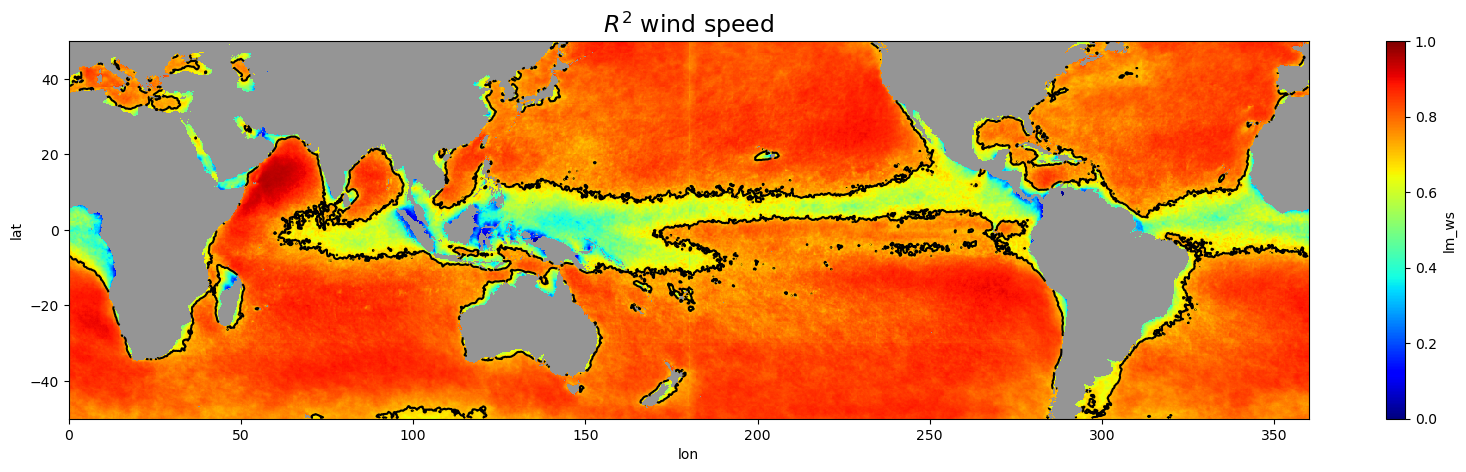

In [16]:
# some plot
fig, ax = plt.subplots(1,1, figsize=(20,5), dpi=100, facecolor='w')
(np.isnan(linmodels.lm_ws[0])).where(np.isnan(linmodels.lm_ws[0])).plot(ax=ax, add_colorbar=False, cmap='Greys')
linmodels.lm_ws.sel(parameter='rsquared').plot(cmap='jet', ax=ax, vmin=0, vmax=1)
linmodels.lm_ws.sel(parameter='rsquared').plot.contour(levels=[0.7], colors='k', ax=ax)
ax.set_title('$R^2$ wind speed', fontsize=17)

Text(0.5, 1.0, '$R^2$ zonal wind')

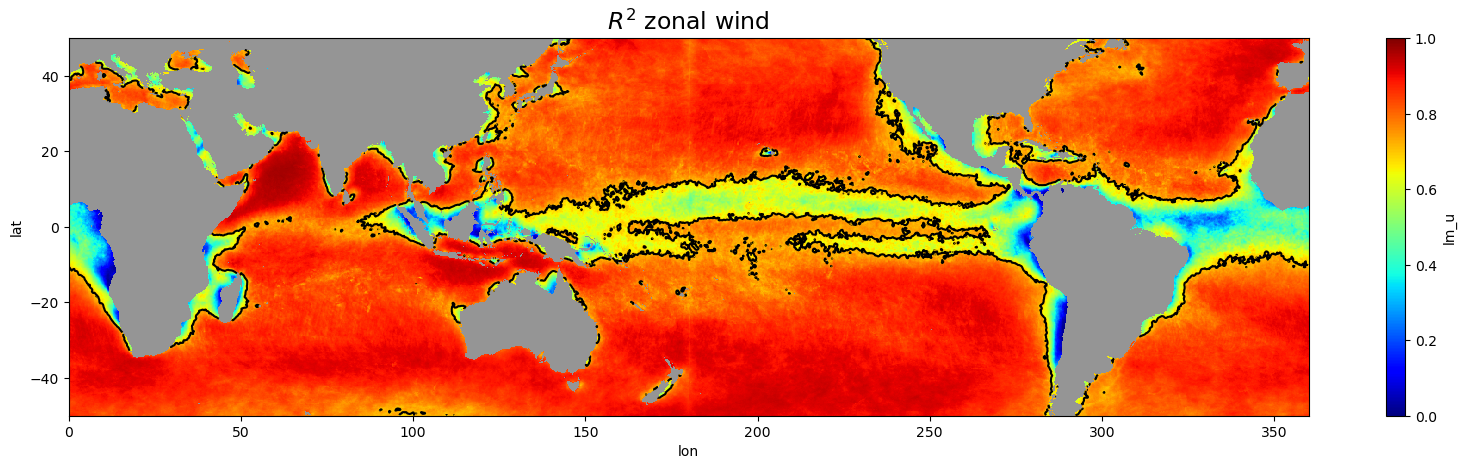

In [17]:
# some plot
fig, ax = plt.subplots(1,1, figsize=(20,5), dpi=100, facecolor='w')
(np.isnan(linmodels.lm_ws[0])).where(np.isnan(linmodels.lm_ws[0])).plot(ax=ax, add_colorbar=False, cmap='Greys')
linmodels.lm_u.sel(parameter='rsquared').plot(cmap='jet', ax=ax, vmin=0, vmax=1)
linmodels.lm_u.sel(parameter='rsquared').plot.contour(levels=[0.7], colors='k', ax=ax)
ax.set_title('$R^2$ zonal wind', fontsize=17)

Text(0.5, 1.0, '$R^2$ meridional wind')

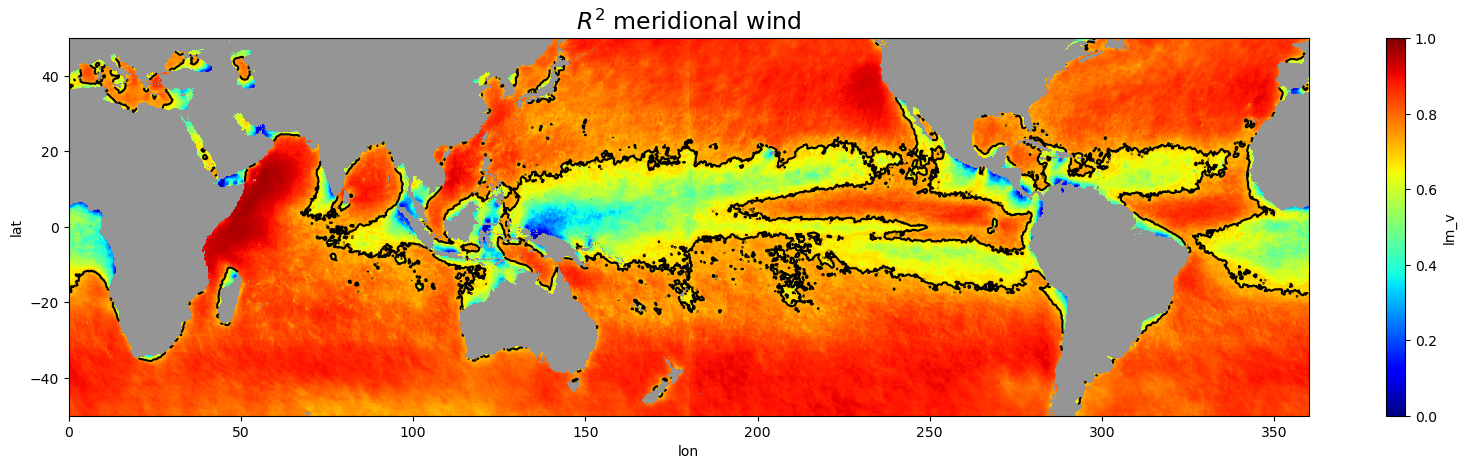

In [18]:
# some plot
fig, ax = plt.subplots(1,1, figsize=(20,5), dpi=100, facecolor='w')
(np.isnan(linmodels.lm_ws[0])).where(np.isnan(linmodels.lm_ws[0])).plot(ax=ax, add_colorbar=False, cmap='Greys')
linmodels.lm_v.sel(parameter='rsquared').plot(cmap='jet', ax=ax, vmin=0, vmax=1)
linmodels.lm_v.sel(parameter='rsquared').plot.contour(levels=[0.7], colors='k', ax=ax)
ax.set_title('$R^2$ meridional wind', fontsize=17)

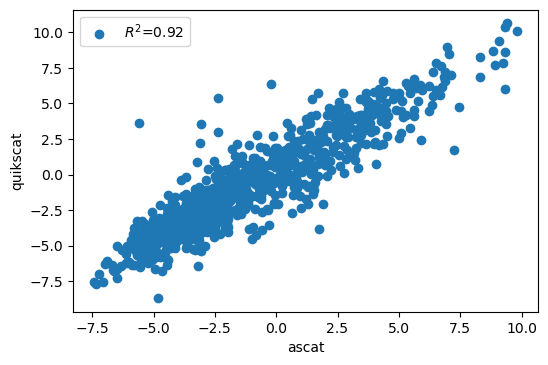

In [ ]:
# check relationship for some points
plt.figure(dpi=100, facecolor='w')
x,y=ascat['u'].sel(lon=280, lat=-30, method='nearest'),quikscat['u'].sel(lon=280, lat=-30, method='nearest')
r = apply_linmodel(x,y,'rvalue')
plt.scatter(x,y,
            label='$R^2$={:.2f}'.format(r))
plt.xlabel('ascat')
plt.ylabel('quikscat')
plt.legend()

---

### <center> Now i will use the calculated parameters to build a continuos scatterometer dataset just for the south-east pacific. 

Since the wind speed magnitude has the best correlation coefficient i will use that variable to merge the datasets, and then keeping the direction i will modify the components. As a first experiment i will constraint the domain only to the Chile-Peru coastline. 

In [35]:
# load quikscat data
def preprocess(data):
    """
    Simple preprocessing function to apply to every ascat/quikscat file
    This just changes some names and modify the lon coordinate
    from -180-180 to 0-360
    """
    print(data.time.dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze().drop('depth')
    data = data[['eastward_wind',
                 'northward_wind',
                 'wind_speed']]
    # data = data.rename({
    #              'eastward_wind':'u',
    #              'northward_wind':'v',
    #              'wind_speed':'ws'})
    data = data.sel(lat=slice(-40,10))
    data.coords['lon'] = xr.where(data.lon<0,data.lon+360,data.lon)
    data = data.sortby('lon').sel(lon=slice(260,291))
    return data.compute()


# load all ascat dataset after the overlapping period
time = pd.date_range("1999-10-28",(overlap_period[-1]).strftime('%F'))
quikscat = [glob('data/QuikSCAT/{}*'.format(d.strftime('%Y%m%d'))) for d in time]
quikscat = sum(quikscat,[])
quikscat = xr.open_mfdataset(quikscat, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)
quikscat['wdir'] = (90-np.rad2deg(np.arctan2(-quikscat.northward_wind,-quikscat.eastward_wind)))%360

['2001-09-24']
['2002-09-17']
['2002-08-09']
['2003-02-27']
['2003-06-29']
['2003-07-22']
['2005-06-03']
['2005-11-02']
['2005-12-09']
['2002-10-10']
['2005-07-18']
['2009-10-07']
['2007-10-02']
['2005-04-29']
['2005-06-07']
['2005-06-19']
['2004-12-28']
['2002-12-23']
['2006-10-07']
['2000-07-25']
['2006-10-28']
['2008-02-08']
['2006-03-03']
['2004-12-08']
['2000-07-21']
['2004-07-04']
['2009-04-23']
['2007-06-18']
['2009-08-17']
['2009-04-21']
['2001-10-28']
['2006-11-12']
['2006-11-24']
['2000-07-17']
['2005-07-17']
['2006-09-03']
['2002-05-31']
['2003-07-08']
['2003-01-08']
['2004-12-01']
['2000-04-28']
['2004-12-13']
['2007-10-17']
['2000-04-09']
['2006-07-14']
['2007-06-19']
['2000-02-28']
['2007-12-22']
['2009-03-08']
['2000-01-06']
['2000-07-22']
['2005-10-14']
['2007-01-14']
['2005-06-30']
['2004-06-03']
['2006-10-18']
['2008-03-16']
['2007-05-04']
['2005-05-04']
['2001-12-26']
['2007-08-07']
['2008-03-01']
['2004-06-22']
['2001-07-14']['2002-05-08']

['2000-12-07']
['2000-12-

In [42]:
# compute wind variables only from wind speed and direction
quikscat['nws']   = quikscat['wind_speed'].copy()
quikscat['nu']    = quikscat['nws']*np.cos(((90-quikscat['wdir'])%360+180)*np.pi/180)
quikscat['nv']    = quikscat['nws']*np.sin(((90-quikscat['wdir'])%360+180)*np.pi/180)
quikscat['ntau']  = (('time','lat','lon'),stress(quikscat['nws']))
quikscat['ntaux'] = quikscat['ntau']*np.cos(((90-quikscat['wdir'])%360+180)*np.pi/180)
quikscat['ntauy'] = quikscat['ntau']*np.sin(((90-quikscat['wdir'])%360+180)*np.pi/180)

In [44]:
# Change attributes and coordinates
dummy  = xr.open_dataset('data/QuikSCAT/1999102800_1999102900_daily-ifremer-L3-MWF-GLO-20130204102807-01.0.nc')
nquikscat = quikscat[['nws','nu','nv','ntau','ntaux','ntauy']] 
nquikscat = nquikscat.rename({'lat':'latitude','lon':'longitude',
                              'nws':'wind_speed','nu':'eastward_wind','nv':'northward_wind',
                             'ntau':'wind_stress','ntaux':'surface_downward_eastward_stress','ntauy':'surface_downward_northward_stress'})
nquikscat.coords['longitude'] = nquikscat.longitude-360
nquikscat.longitude.attrs = dummy.longitude.attrs
nquikscat.latitude.attrs  = dummy.latitude.attrs
for k in nquikscat.keys():
    nquikscat[k].attrs = dummy[k].attrs

In [4]:
# load ascat data
def preprocess(data):
    """
    Simple preprocessing function to apply to every ascat/quikscat file
    This just changes some names and modify the lon coordinate
    from -180-180 to 0-360
    """
    print(data.time.dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze().drop('depth')
    data = data[['eastward_wind',
                 'northward_wind',
                 'wind_speed']]
    data = data.rename({
                 'eastward_wind':'u',
                 'northward_wind':'v',
                 'wind_speed':'ws'})
    data = data.sel(lat=slice(-40,10))
    data.coords['lon'] = xr.where(data.lon<0,data.lon+360,data.lon)
    data = data.sortby('lon').sel(lon=slice(260,291))
    return data.compute()


# load all ascat dataset after the overlapping period
time = pd.date_range((overlap_period[-1]+pd.Timedelta(days=1)).strftime('%F'),'2022-12-31')
ascat = [glob('data/ASCAT/{}*'.format(d.strftime('%Y%m%d'))) for d in time]
ascat = sum(ascat,[])
ascat = xr.open_mfdataset(ascat, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)

ascat['wdir'] = (90-np.rad2deg(np.arctan2(-ascat.v,-ascat.u)))%360

['2011-06-05']
['2017-12-14']
['2018-09-29']
['2019-04-29']
['2020-12-04']
['2012-11-27']
['2020-08-17']
['2010-06-09']
['2011-09-19']
['2020-01-02']
['2011-12-14']
['2016-09-10']
['2017-07-27']
['2019-05-19']
['2011-08-17']
['2020-07-14']
['2019-04-17']
['2015-10-21']
['2011-10-29']
['2015-07-13']
['2021-05-07']
['2010-04-11']
['2011-05-26']
['2017-02-24']
['2010-01-15']
['2013-02-27']
['2016-03-29']
['2022-07-07']
['2012-09-16']
['2017-05-03']
['2017-08-14']
['2021-10-23']
['2019-01-15']
['2010-12-13']
['2011-01-27']
['2014-03-29']
['2020-06-23']
['2014-04-02']
['2022-01-15']
['2016-01-09']
['2016-03-28']
['2013-07-26']
['2022-08-26']
['2011-05-23']
['2017-01-12']
['2017-06-17']
['2016-06-13']
['2014-04-19']
['2019-08-23']
['2013-12-13']
['2017-04-15']
['2015-01-03']
['2016-06-26']
['2017-04-26']
['2013-08-20']
['2014-07-20']
['2010-08-15']
['2015-10-08']
['2019-02-08']
['2015-11-27']
['2013-01-10']
['2015-03-24']
['2015-07-03']
['2011-06-19']
['2011-03-14']
['2015-12-10']
['2010-01-

In [5]:
# compute wind variables only from wind speed and direction
ascat['nws']   = ascat['ws']*linmodels['lm_ws'].sel(parameter='slope')+linmodels['lm_ws'].sel(parameter='intercept')
ascat['nu']    = ascat['nws']*np.cos(((90-ascat['wdir'])%360+180)*np.pi/180)
ascat['nv']    = ascat['nws']*np.sin(((90-ascat['wdir'])%360+180)*np.pi/180)
ascat['ntau']  = (('time','lat','lon'),stress(ascat['nws']))
ascat['ntaux'] = ascat['ntau']*np.cos(((90-ascat['wdir'])%360+180)*np.pi/180)
ascat['ntauy'] = ascat['ntau']*np.sin(((90-ascat['wdir'])%360+180)*np.pi/180)

In [27]:
# Change attributes and coordinates
dummy  = xr.open_dataset('data/ASCAT/2007032100_2007032200_daily-ifremer-L3-MWF-GLO-20110531232401-01.0.nc')
nascat = ascat[['nws','nu','nv','ntau','ntaux','ntauy']] 
nascat = nascat.rename({'lat':'latitude','lon':'longitude',
                        'nws':'wind_speed','nu':'eastward_wind','nv':'northward_wind',
                        'ntau':'wind_stress','ntaux':'surface_downward_eastward_stress','ntauy':'surface_downward_northward_stress'})
nascat.coords['longitude'] = nascat.longitude-360
nascat.longitude.attrs = dummy.longitude.attrs
nascat.latitude.attrs  = dummy.latitude.attrs
for k in nascat.keys():
    nascat[k].attrs = dummy[k].attrs

In [48]:
nascat

<xarray.Dataset>
Dimensions:                            (time: 4751, latitude: 200,
                                        longitude: 124)
Coordinates:
  * time                               (time) datetime64[ns] 2009-11-18T12:00...
  * latitude                           (latitude) float64 -39.88 ... 9.875
  * longitude                          (longitude) float64 -99.88 ... -69.12
Data variables:
    wind_speed                         (time, latitude, longitude) float64 11...
    eastward_wind                      (time, latitude, longitude) float64 9....
    northward_wind                     (time, latitude, longitude) float64 5....
    wind_stress                        (time, latitude, longitude) float64 0....
    surface_downward_eastward_stress   (time, latitude, longitude) float64 0....
    surface_downward_northward_stress  (time, latitude, longitude) float64 0....
Attributes: (12/22)
    Conventions:              CF-1.4
    title:                    Daily ASCAT global wind field
    references:               Bentamy, A.; Croize-Fillon, 2010: Gridded surfa...
    institution:              ifremer
    source:                   produced at 2011-04-15
    bulletin_date:            2011-04-15
    ...                       ...
    grid_resolution:          0.250 degree
    file_quality_index:       0.0
    time_resolution:          daily
    objective_method:         krigeage
    polar_sea_ice_mask_date:  2009-11-18
    creation_date_time:       20110415T165512

In [63]:
global_attrs = nascat.attrs.copy()
global_attrs['title']   = 'MSCAT: Merged QuikSCAT and ASCAT gridded wind fields'
global_attrs['contact'] = 'lucas.glasner@ceaza.cl'
global_attrs['start_date'] = '1999-10-28'
global_attrs['stop_date']  = '2022-12-31'
global_attrs['institution'] = 'ceaza'
global_attrs['northernmost_latitude'] = nascat.latitude.max().item()
global_attrs['southernmost_latitude'] = nascat.latitude.min().item()
global_attrs['easternmost_longitude'] = nascat.longitude.max().item()
global_attrs['westernmost_longitude'] = nascat.longitude.min().item()
global_attrs.pop('creation_date_time')
global_attrs.pop('bulletin_date')
global_attrs.pop('creation_date')
global_attrs

{'Conventions': 'CF-1.4',
 'title': 'MSCAT: Merged QuikSCAT and ASCAT gridded wind fields',
 'references': 'Bentamy, A.; Croize-Fillon, 2010: Gridded surface wind fields from Metop/ASCAT measurements, International Journal of Remote Sensing',
 'institution': 'ceaza',
 'source': 'produced at 2011-04-15',
 'contact': 'lucas.glasner@ceaza.cl',
 'start_time': '12:00:00',
 'stop_time': '12:00:00',
 'start_date': '1999-10-28',
 'stop_date': '2022-12-31',
 'northernmost_latitude': 9.875,
 'southernmost_latitude': -39.875,
 'easternmost_longitude': -69.125,
 'westernmost_longitude': -99.875,
 'grid_resolution': '0.250 degree',
 'file_quality_index': 0.0,
 'time_resolution': 'daily',
 'objective_method': 'krigeage'}

In [93]:
# Create new dataset
mscat       = xr.concat([nquikscat, nascat], 'time').sortby('time')
mscat.attrs = global_attrs

In [100]:
# Make dataset continuos along time dimension
mscat = mscat.drop_duplicates('time')
mscat = mscat.reindex({'time':pd.date_range('1999-10-28','2022-12-31', freq='d')+pd.Timedelta(hours=12)})

In [112]:
# Save to disk
encoding_opts = {var: dict(zlib=True, complevel=5) for var in mscat.data_vars}
for yr in range(1999,2022+1):
    print(yr)
    mscat.sel(time=f'{yr}').to_netcdf(f'/home/lucas/storage/MSCAT/MSCAT_Y{yr}.nc', encoding=encoding_opts)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


#### Compute climatology of the new dataset

In [205]:
from utils import compute_climatology

In [117]:
# Compute climatology
mscat = xr.open_mfdataset('~/storage/MSCAT/*.nc').compute().convert_calendar('noleap')
mclimatology = mscat.groupby('time.month').mean()
dclimatology = compute_climatology(mscat, 'time')

# standard deviations
mclimatology_std = mscat.groupby('time.month').std()
dclimatology_std = compute_climatology(mscat, 'time', kind='std')

In [188]:
# change varible name for standard deviations
mclimatology_std = mclimatology_std.rename({keys:keys+'_std' for keys in mclimatology_std.data_vars})
dclimatology_std = dclimatology_std.rename({keys:keys+'_std' for keys in dclimatology_std.data_vars})

In [200]:
# add metadata to standard deviations
for k in mscat.keys():
    mclimatology_std[k+'_std'].attrs = mscat[k].attrs.copy()
    dclimatology_std[k+'_std'].attrs = mscat[k].attrs.copy()
    
    mclimatology_std[k+'_std'].attrs['long_name'] = mclimatology_std[k+'_std'].attrs['long_name']+' standard deviation'
    dclimatology_std[k+'_std'].attrs['long_name'] = dclimatology_std[k+'_std'].attrs['long_name']+' standard deviation'
    try:
        mclimatology_std[k+'_std'].attrs['standard_name'] = mclimatology_std[k+'_std'].attrs['standard_name']+' standard deviation'
    except:
        pass
    try:
        dclimatology_std[k+'_std'].attrs['standard_name'] = dclimatology_std[k+'_std'].attrs['standard_name']+' standard deviation'
    except:
        pass

In [202]:
# add metadata to mena values and global dataset
mclimatology.attrs = mscat.attrs.copy()
dclimatology.attrs = mscat.attrs.copy()

for k in mscat.keys():
    mclimatology[k].attrs = mscat[k].attrs.copy()
    dclimatology[k].attrs = mscat[k].attrs.copy()
mclimatology.attrs['title'] = 'MSCAT Monthly wind climatology 2000-2020'
dclimatology.attrs['title'] = 'MSCAT Daily wind climatology 2000-2020'

In [204]:
# save to disk
xr.merge([mclimatology,mclimatology_std]).to_netcdf('~/storage/MSCAT/MSCAT_monthly_climatology_2000-2022.nc')
xr.merge([dclimatology,dclimatology_std]).to_netcdf('~/storage/MSCAT/MSCAT_daily_climatology_2000-2022.nc')